# Deeper dive into time series data


In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import datetime

SEED = 99

from sklearn import preprocessing, svm
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_absolute_error as MAE, r2_score, mean_squared_error as MSE

import statsmodels.tsa.api as smt
import statsmodels.api as sm

# ## For Arima
import pmdarima

## For Lstm
# import tensorflow as tf

# # ## For Prophet
# from fbprophet import Prophet

from warnings import filterwarnings

filterwarnings('ignore') #for the sake of posting online

In [2]:
feat_train = pd.read_csv('dengue_features_train.csv', parse_dates = ['week_start_date'])
label_train = pd.read_csv("dengue_labels_train.csv")

#Different versions of the same data for trying out different methods
data = feat_train.merge(label_train, on=['city', 'year', 'weekofyear'])
data_train = data.set_index(['city', 'year', 'weekofyear'])
data_monthly = data.set_index('week_start_date')

In [3]:
#Split data on city
data_sj = data_train.loc['sj']
data_iq = data_train.loc['iq']

## format datetime column
data_sj["date"] = pd.to_datetime(data_sj['week_start_date'], format='%d.%m.%Y')## create time series
ts = data_sj.groupby("date")["total_cases"].sum()

data_iq["date"] = pd.to_datetime(data_iq['week_start_date'], format='%d.%m.%Y')## create time series
ts_iq = data_iq.groupby("date")["total_cases"].sum()

In [4]:
#Resample on month
ts_sj_monthly = data_monthly.total_cases[data_monthly.city == 'sj'].resample('M').sum()
ts_iq_monthly = data_monthly.total_cases[data_monthly.city == 'iq'].resample('M').sum()

<AxesSubplot:xlabel='date'>

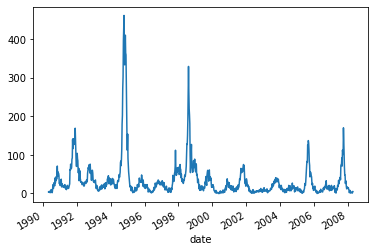

In [5]:
ts.plot()

<AxesSubplot:xlabel='date'>

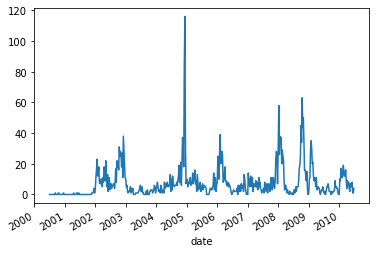

In [6]:
ts_iq.plot()

In [7]:
'''
Given the great irregularity of the inital flat case count (most 
likely a data capturing failure), I will just remove the data here 
before 2002.
'''

ts_iq = ts_iq["1-1-2002":]
ts_iq_monthly = ts_iq_monthly["1-1-2002":]

In [8]:
'''
Find outliers using sklearn unsupervised support vetcor machine.
:parameter
    :param ts: pandas Series
    :param perc: float - percentage of outliers to look for
:return
    dtf with raw ts, outlier 1/0 (yes/no), numeric index
'''
def find_outliers(ts, perc=0.01, figsize=(15,5)):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"] = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Outliers detection: found"
           +str(sum(dtf_outliers["outlier"]==1)))
    ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
            color="black")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
               y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers

In [9]:
'''
Interpolate outliers in a ts.
'''
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method="linear")
    ax = ts.plot(figsize=figsize, color="red", alpha=0.5,
         title="Remove outliers", label="original", legend=True)
    ts_clean.plot(ax=ax, grid=True, color="black",
                  label="interpolated", legend=True)
    plt.show()
    return ts_clean

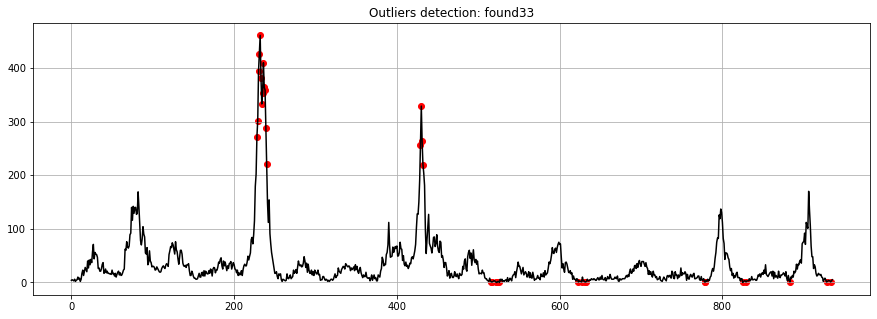

In [10]:
#San Juan outliers
dtf_outliers = find_outliers(ts, perc=0.05)

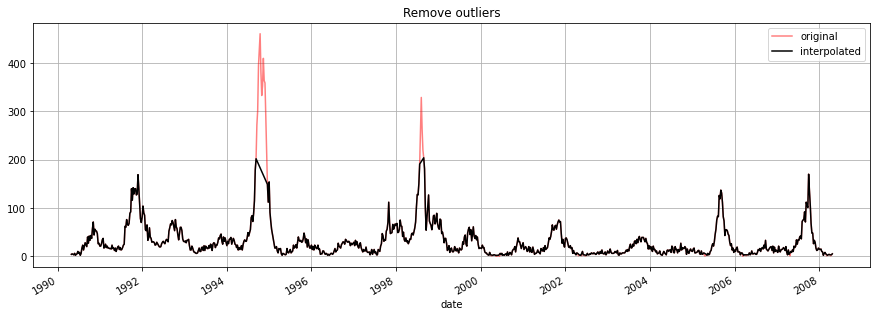

In [11]:
## outliers index position
outliers_index_pos = dtf_outliers[dtf_outliers["outlier"]==1].index

## exclude outliers
ts_clean = remove_outliers(ts, outliers_idx=outliers_index_pos)

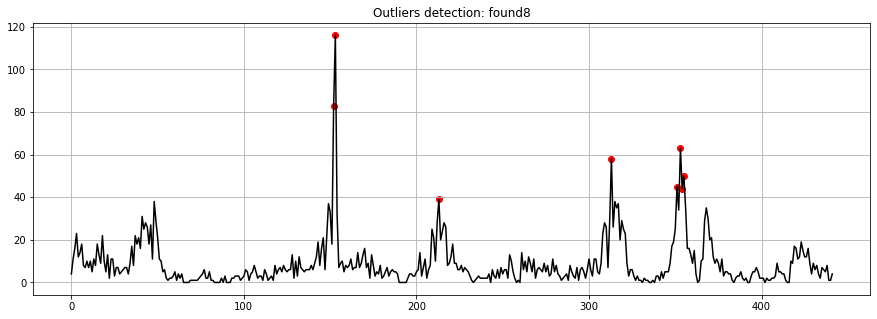

In [12]:
#Iquitos outliers
dtf_outliers_iq = find_outliers(ts_iq, perc=0.05)

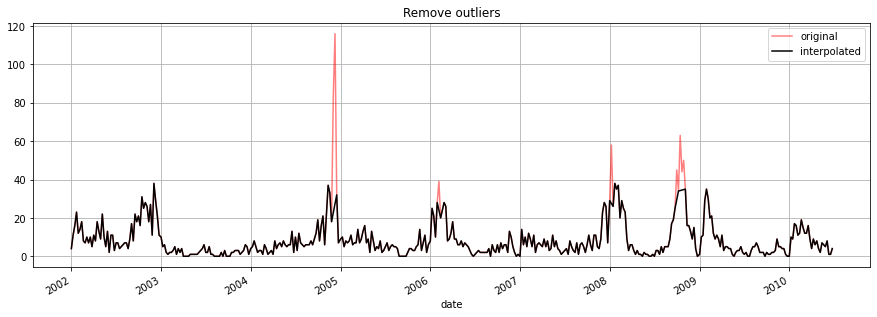

In [13]:
## outliers index position
outliers_index_pos_iq = dtf_outliers_iq[dtf_outliers_iq["outlier"]==1].index

## exclude outliers
ts_iq_clean = remove_outliers(ts_iq, outliers_idx=outliers_index_pos_iq)

In [14]:
'''
Test stationarity by:
    - running Augmented Dickey-Fuller test with 95%
    - plotting mean and variance of a sample from data
    - plottig autocorrelation and partial autocorrelation
'''
def test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30, figsize= 
                              (15,10)):
    with plt.style.context(style='bmh'):
        ## set figure
        fig = plt.figure(figsize=figsize)
        ts_ax = plt.subplot2grid(shape=(2,2), loc=(0,0), colspan=2)
        pacf_ax = plt.subplot2grid(shape=(2,2), loc=(1,0))
        acf_ax = plt.subplot2grid(shape=(2,2), loc=(1,1))
        
        ## plot ts with mean/std of a sample from the first x% 
        dtf_ts = ts.to_frame(name="ts")
        sample_size = int(len(ts)*sample)
        dtf_ts["mean"] = dtf_ts["ts"].head(sample_size).mean()
        dtf_ts["lower"] = dtf_ts["ts"].head(sample_size).mean() + dtf_ts["ts"].head(sample_size).std()
        dtf_ts["upper"] = dtf_ts["ts"].head(sample_size).mean() - dtf_ts["ts"].head(sample_size).std()
        dtf_ts["ts"].plot(ax=ts_ax, color="black", legend=False)
        dtf_ts["mean"].plot(ax=ts_ax, legend=False, color="red",
                            linestyle="--", linewidth=0.7)
        ts_ax.fill_between(x=dtf_ts.index, y1=dtf_ts['lower'], 
                y2=dtf_ts['upper'], color='lightskyblue', alpha=0.4)
        dtf_ts["mean"].head(sample_size).plot(ax=ts_ax,
                legend=False, color="red", linewidth=0.9)
        ts_ax.fill_between(x=dtf_ts.head(sample_size).index, 
                           y1=dtf_ts['lower'].head(sample_size), 
                           y2=dtf_ts['upper'].head(sample_size),
                           color='lightskyblue')
        
        ## test stationarity (Augmented Dickey-Fuller)
        adfuller_test = sm.tsa.stattools.adfuller(ts, maxlag=maxlag,
                                                  autolag="AIC")
        adf, p, critical_value = adfuller_test[0], adfuller_test[1], adfuller_test[4]["5%"]
        p = round(p, 3)
        conclusion = "Stationary" if p < 0.05 else "Non-Stationary"
        ts_ax.set_title('Dickey-Fuller Test 95%: '+conclusion+
                        '(p value: '+str(p)+')')
        
        ## pacf (for AR) e acf (for MA) 
        smt.graphics.plot_pacf(ts, lags=maxlag, ax=pacf_ax, 
                 title="Partial Autocorrelation (for AR component)")
        smt.graphics.plot_acf(ts, lags=maxlag, ax=acf_ax,
                 title="Autocorrelation (for MA component)")
        plt.tight_layout()

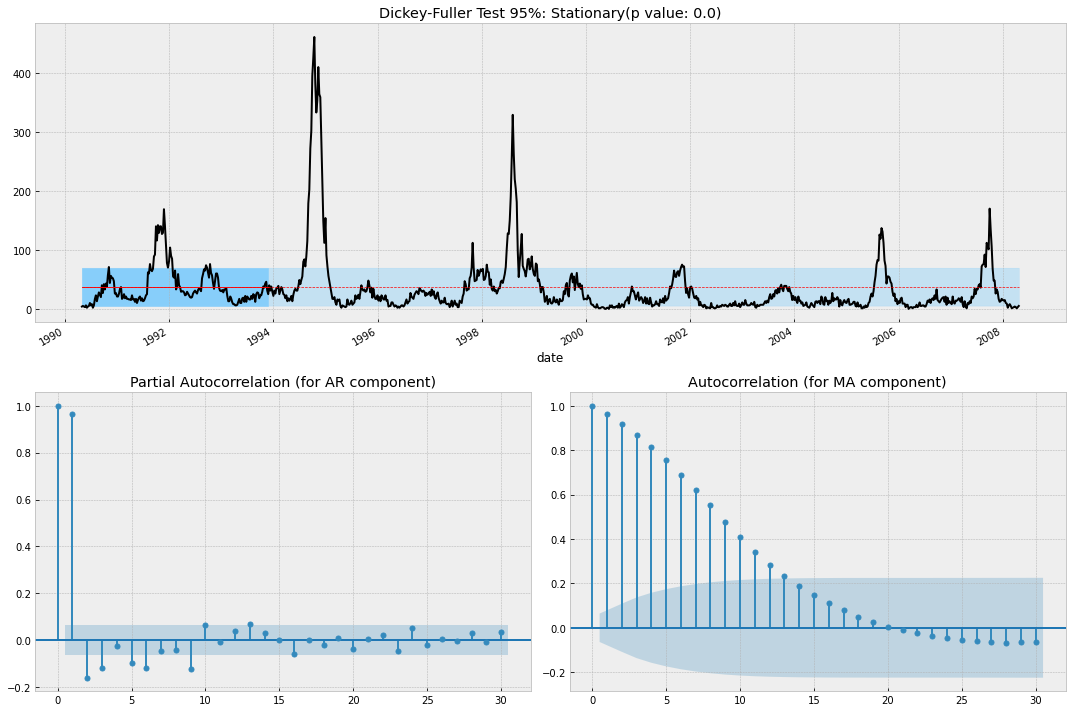

In [15]:
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30)

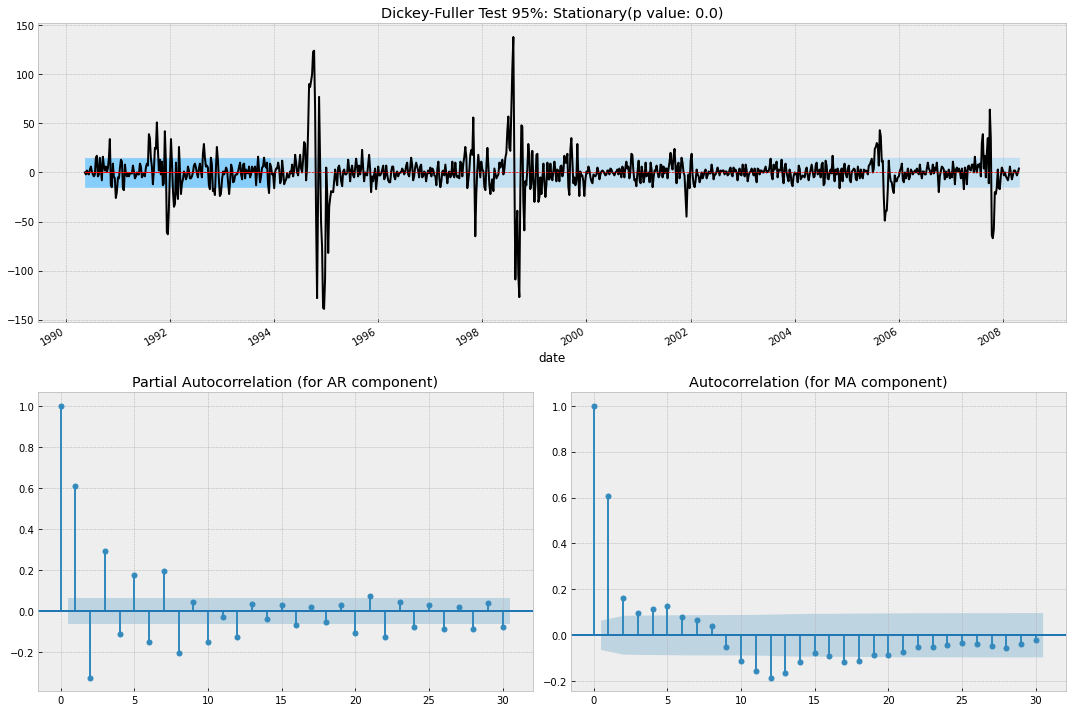

In [16]:
diff_ts = ts - ts.shift(2)
diff_ts = diff_ts[(pd.notnull(diff_ts))]

test_stationarity_acf_pacf(diff_ts, sample=0.20, maxlag=30)

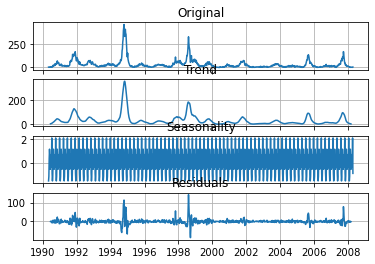

In [17]:
decomposition = smt.seasonal_decompose(ts, freq=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False)
ax[0].plot(ts)
ax[0].set_title('Original')
ax[0].grid(True) 
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[1].grid(True)  
ax[2].plot(seasonal)
ax[2].set_title('Seasonality')
ax[2].grid(True)  
ax[3].plot(residual)
ax[3].set_title('Residuals')
ax[3].grid(True)

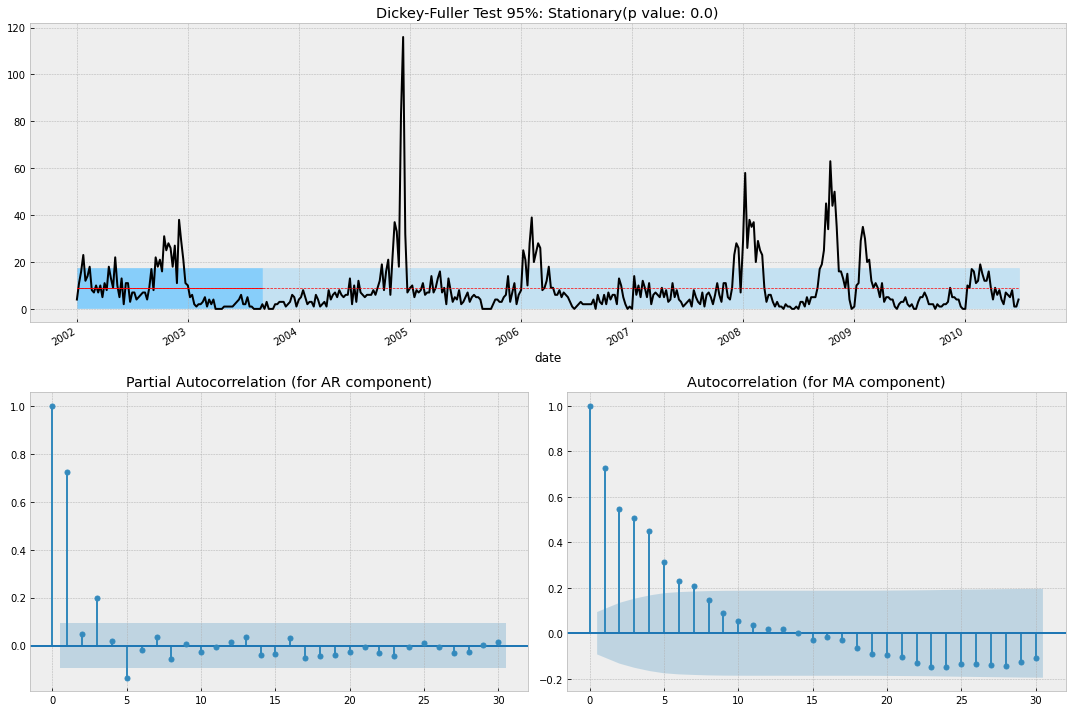

In [18]:
test_stationarity_acf_pacf(ts_iq, sample=0.20, maxlag=30)

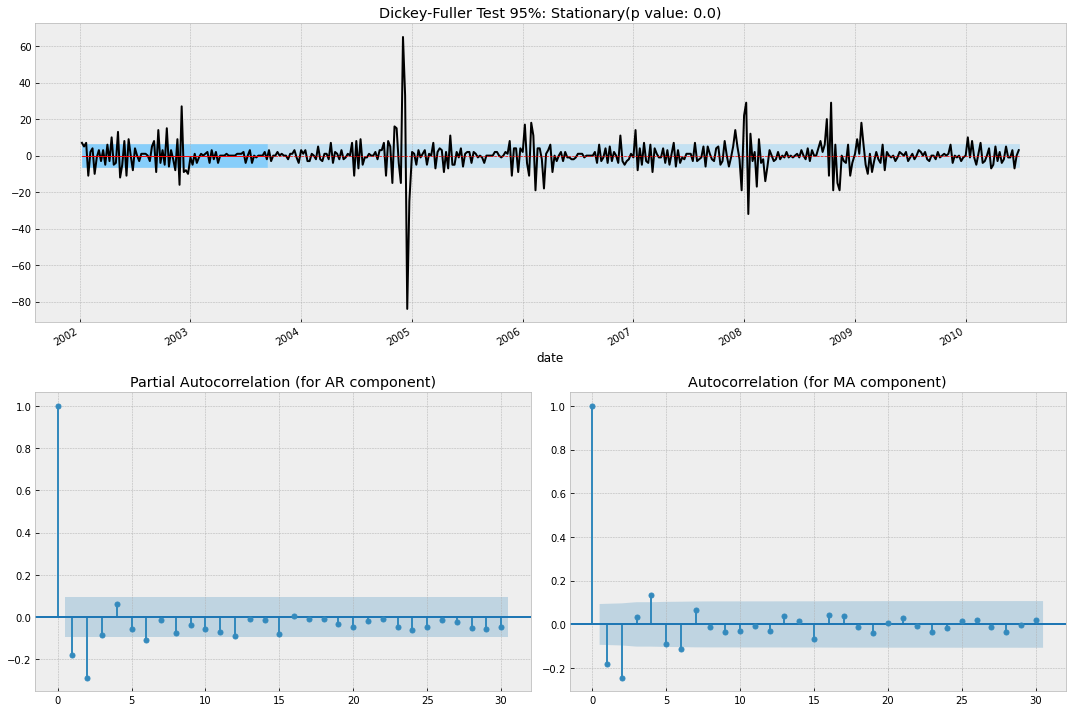

In [19]:
diff_ts_iq = ts_iq - ts_iq.shift(1)
diff_ts_iq = diff_ts_iq[(pd.notnull(diff_ts_iq))]

test_stationarity_acf_pacf(diff_ts_iq, sample=0.20, maxlag=30)

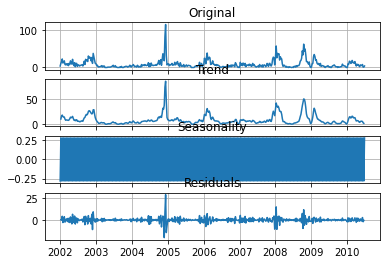

In [20]:
decomposition_iq = smt.seasonal_decompose(ts_iq, freq=2)
trend_iq = decomposition_iq.trend
seasonal_iq = decomposition_iq.seasonal
residual_iq = decomposition_iq.resid   
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False)
ax[0].plot(ts_iq)
ax[0].set_title('Original')
ax[0].grid(True) 
ax[1].plot(trend_iq)
ax[1].set_title('Trend')
ax[1].grid(True)  
ax[2].plot(seasonal_iq)
ax[2].set_title('Seasonality')
ax[2].grid(True)  
ax[3].plot(residual_iq)
ax[3].set_title('Residuals')
ax[3].grid(True)

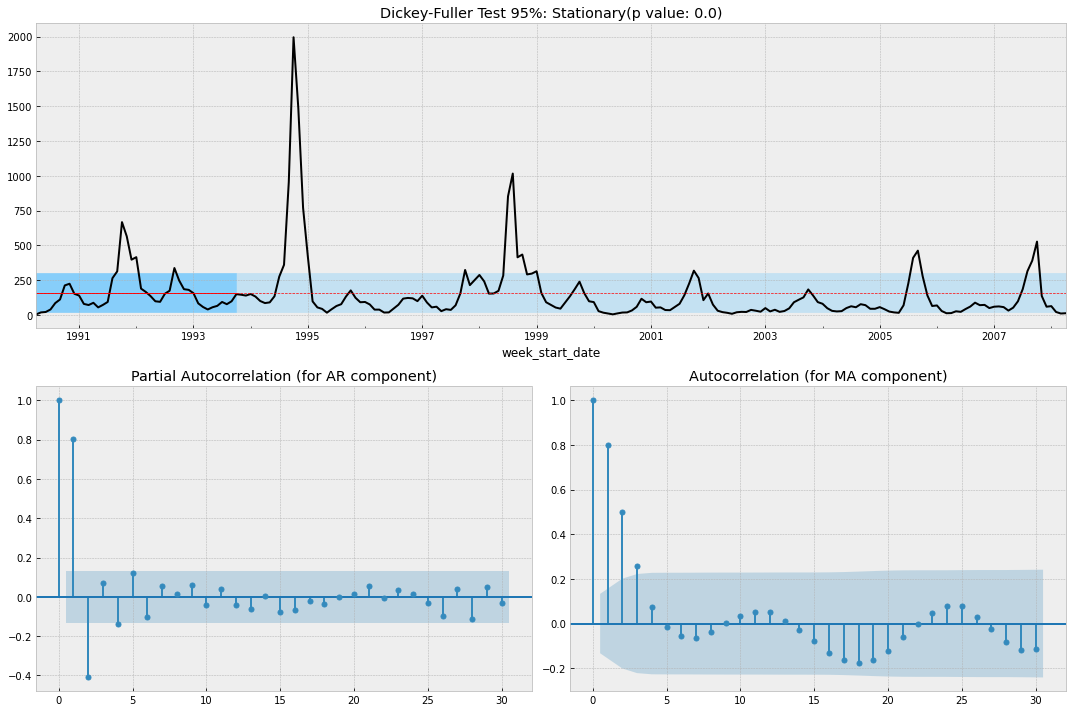

In [21]:
#now let's try the resampled monthly data
test_stationarity_acf_pacf(ts_sj_monthly, sample=0.20, maxlag=30)

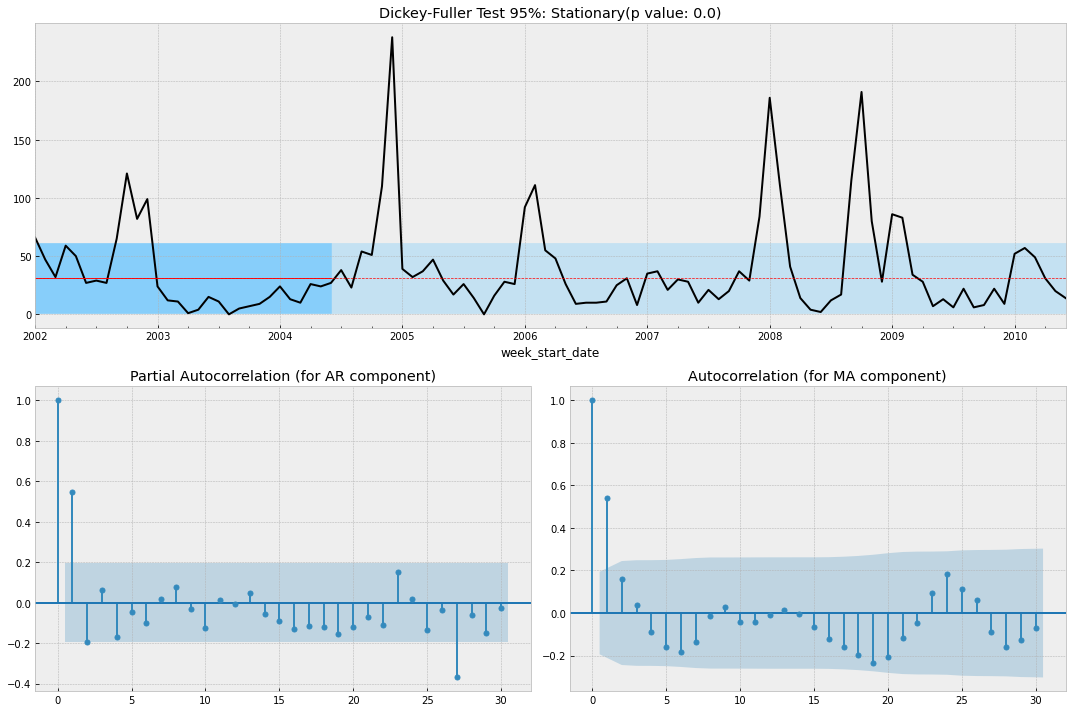

In [22]:
test_stationarity_acf_pacf(ts_iq_monthly, sample=0.30, maxlag=30)

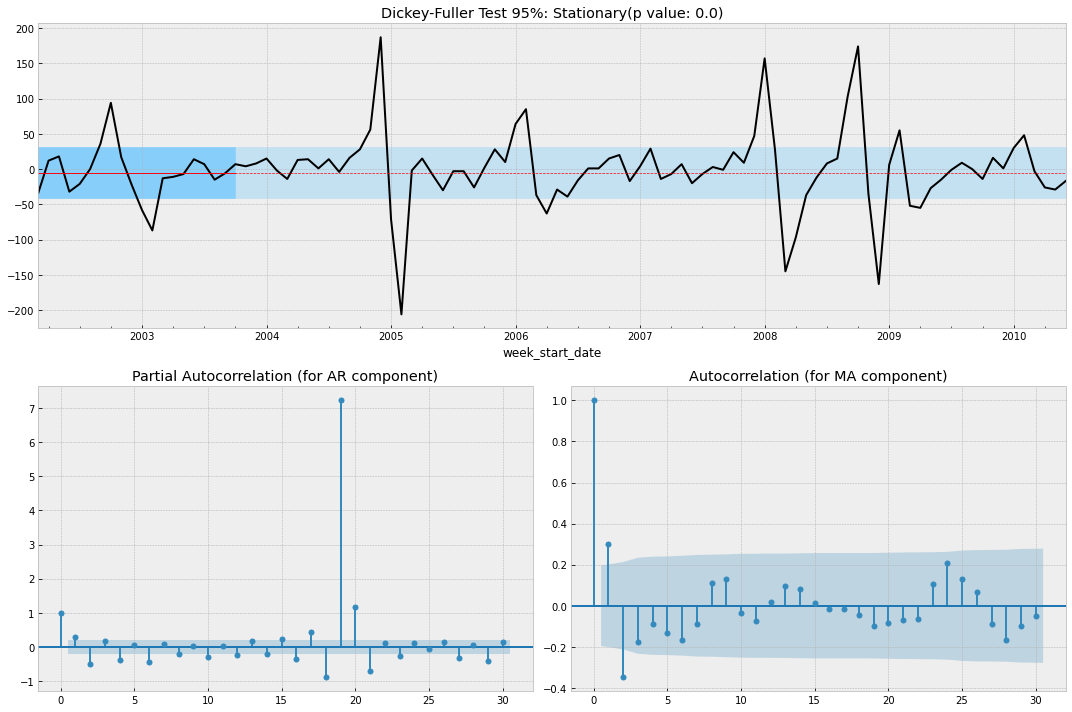

In [23]:
diff_ts_iq_monthly = ts_iq_monthly - ts_iq_monthly.shift(2)
diff_ts_iq_monthly = diff_ts_iq_monthly[(pd.notnull(diff_ts_iq_monthly))]

test_stationarity_acf_pacf(diff_ts_iq_monthly, sample=0.20, maxlag=30)

# Modeling: SARIMAX model

In [24]:
data_sj = data_sj.reset_index()
data_iq = data_iq.reset_index()

data_sj = data_sj.drop(['year','weekofyear','week_start_date'], axis=1)
data_iq = data_iq.drop(['year','weekofyear','week_start_date'], axis=1)

In [25]:
#Seperate exogenous (not label) dataset
ts_exog_sj = data_sj.drop(['total_cases'],axis=1).set_index('date')
ts_exog_iq = data_iq.drop(['total_cases'],axis=1).set_index('date')

ts_exog_iq = ts_exog_iq['2002-1-1':] #We are eliminating everything before 2002

In [26]:
# remember I have these
ts.head(), ts_iq.head()

(date
 1990-04-30    4
 1990-05-07    5
 1990-05-14    4
 1990-05-21    3
 1990-05-28    6
 Name: total_cases, dtype: int64,
 date
 2002-01-01     4
 2002-01-08    11
 2002-01-15    16
 2002-01-22    23
 2002-01-29    12
 Name: total_cases, dtype: int64)

In [27]:
ts_exog_sj2 = ts_exog_sj.fillna(method='ffill')
ts_exog_iq2 = ts_exog_iq.fillna(method='ffill')

#Resample for monthly model
ts_exog_sj_monthly = ts_exog_sj2.resample('M').mean()
ts_exog_iq_monthly = ts_exog_iq2.resample('M').mean()

# ts_exog_iq_monthly = ts_exog_iq_monthly['2002-1-1':]

In [28]:
'''
Split train/test from any given data point.
:parameter
    :param ts: pandas Series
    :param test: num or str - test size (ex. 0.20) or index position
                 (ex. "yyyy-mm-dd", 1000)
:return
    ts_train, ts_test
'''
def split_train_test(ts, test=0.20, plot=True, figsize=(15,5)):
    ## define splitting point
    if type(test) is float:
        split = int(len(ts)*(1-test))
        perc = test
    elif type(test) is str:
        split = ts.reset_index()[ts.reset_index().iloc[:,0]==test].index[0]
        perc = round(len(ts[split:])/len(ts), 2)
    else:
        split = test
        perc = round(len(ts[split:])/len(ts), 2)
    print("--- splitting at index: ", split, "|", 
          ts.index[split], "| test size:", perc, " ---")
    
    ## split ts
    ts_train = ts.head(split)
    ts_test = ts.tail(len(ts)-split)
    if plot is True:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, 
                               sharey=True, figsize=figsize)
        ts_train.plot(ax=ax[0], grid=True, title="Train", 
                      color="black")
        ts_test.plot(ax=ax[1], grid=True, title="Test", 
                     color="black")
        ax[0].set(xlabel=None)
        ax[1].set(xlabel=None)
        plt.show()
        
    return ts_train, ts_test

--- splitting at index:  748 | 2004-09-16 00:00:00 | test size: 0.2  ---


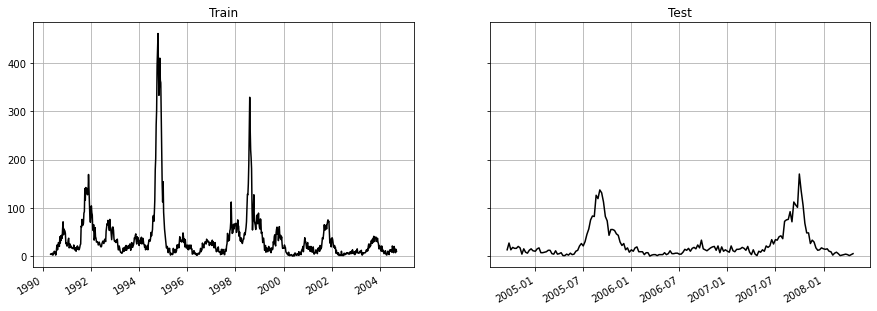

--- splitting at index:  353 | 2008-10-14 00:00:00 | test size: 0.2  ---


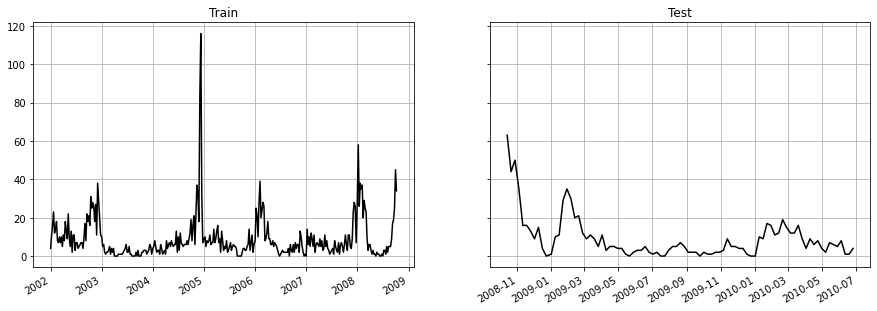

--- splitting at index:  748 | 2004-09-16 00:00:00 | test size: 0.2  ---
--- splitting at index:  353 | 2008-10-14 00:00:00 | test size: 0.2  ---


In [29]:
ts_train_sj, ts_test_sj = split_train_test(ts, test = 0.2)
ts_train_iq, ts_test_iq = split_train_test(ts_iq, test = 0.2)


ts_exog_train_sj, ts_exog_test_sj = split_train_test(ts_exog_sj, test = 0.2, plot=False)

ts_exog_train_sj = ts_exog_train_sj.fillna(method='ffill')
ts_exog_test_sj = ts_exog_test_sj.fillna(method='ffill')
ts_exog_test_sj['ndvi_nw'] = ts_exog_test_sj.fillna((ts_exog_test_sj['ndvi_nw'].mean()))

ts_exog_train_iq, ts_exog_test_iq = split_train_test(ts_exog_iq, test = 0.2, plot=False)

ts_exog_train_iq = ts_exog_train_iq.fillna(method='ffill')
ts_exog_test_iq = ts_exog_test_iq.fillna(method='ffill')
ts_exog_test_iq = ts_exog_test_iq.fillna(method='bfill')


In [30]:
'''
Evaluation metrics for predictions.
:parameter
    :param dtf: DataFrame with columns raw values, fitted training  
                 values, predicted test values
:return
    dataframe with raw ts and forecast
'''
def utils_evaluate_forecast(dtf, title, plot=True, figsize=(20,13)):
    try:
        ## residuals
        dtf["residuals"] = dtf["ts"] - dtf["model"]
        dtf["error"] = dtf["ts"] - dtf["forecast"]
        dtf["error_pct"] = dtf["error"] / dtf["ts"]
        
        ## kpi
        residuals_mean = dtf["residuals"].mean()
        residuals_std = dtf["residuals"].std()
        error_mean = dtf["error"].mean()
        error_std = dtf["error"].std()
        mae = dtf["error"].apply(lambda x: np.abs(x)).mean()
        mape = dtf["error_pct"].apply(lambda x: np.abs(x)).mean()  
        mse = dtf["error"].apply(lambda x: x**2).mean()
        rmse = np.sqrt(mse)  #root mean squared error
        
        ## intervals
        dtf["conf_int_low"] = dtf["forecast"] - 1.96*residuals_std
        dtf["conf_int_up"] = dtf["forecast"] + 1.96*residuals_std
        dtf["pred_int_low"] = dtf["forecast"] - 1.96*error_std
        dtf["pred_int_up"] = dtf["forecast"] + 1.96*error_std
        
        ## plot
        if plot==True:
            fig = plt.figure(figsize=figsize)
            fig.suptitle(title, fontsize=20)   
            ax1 = fig.add_subplot(2,2, 1)
            ax2 = fig.add_subplot(2,2, 2, sharey=ax1)
            ax3 = fig.add_subplot(2,2, 3)
            ax4 = fig.add_subplot(2,2, 4)
            ### training
            dtf[pd.notnull(dtf["model"])][["ts","model"]].plot(color=["black","green"], title="Model", grid=True, ax=ax1)      
            ax1.set(xlabel=None)
            ### test
            dtf[pd.isnull(dtf["model"])][["ts","forecast"]].plot(color=["black","red"], title="Forecast", grid=True, ax=ax2)
            ax2.fill_between(x=dtf.index, y1=dtf['pred_int_low'], y2=dtf['pred_int_up'], color='b', alpha=0.2)
            ax2.fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)     
            ax2.set(xlabel=None)
            ### residuals
            dtf[["residuals","error"]].plot(ax=ax3, color=["green","red"], title="Residuals", grid=True)
            ax3.set(xlabel=None)
            ### residuals distribution
            dtf[["residuals","error"]].plot(ax=ax4, color=["green","red"], kind='kde', title="Residuals Distribution", grid=True)
            ax4.set(ylabel=None)
            plt.show()
            print("Training --> Residuals mean:", np.round(residuals_mean), " | std:", np.round(residuals_std))
            print("Test --> Error mean:", np.round(error_mean), " | std:", np.round(error_std),
                  " | mae:",np.round(mae), " | mape:",np.round(mape*100), "%  | mse:",np.round(mse), " | rmse:",np.round(rmse))
        
        return dtf[["ts","model","residuals","conf_int_low","conf_int_up", 
                    "forecast","error","pred_int_low","pred_int_up"]]
    
    except Exception as e:
        print("--- got error ---")
        print(e)

In [31]:
best_model = pmdarima.auto_arima(ts_sj_monthly, exogenous = ts_exog_sj_monthly, seasonal=True, stationary=False, 
                                 m=12, information_criterion='aic', max_order=20, 
                                 max_p=10, max_d=3, max_q=10, 
                                 max_P=10, max_D=3, max_Q=10,
                                 error_action='ignore')

print("best model --> (p, d, q):", best_model.order, " and  (P, D, Q, s):", best_model.seasonal_order)
print(best_model.summary())

best model --> (p, d, q): (1, 0, 0)  and  (P, D, Q, s): (0, 0, 0, 12)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  217
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1389.353
Date:                Fri, 02 Oct 2020   AIC                           2822.707
Time:                        13:13:47   BIC                           2897.065
Sample:                    04-30-1990   HQIC                          2852.744
                         - 04-30-2008                                         
Covariance Type:                  opg                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
ndvi_ne                                 112.6858    287.387      0.392      0.695    -

In [32]:
import statsmodels.api as sm
from pandas import datetime

'''
Fit SARIMAX (Seasonal ARIMA with External Regressors):  
    y[t+1] = (c + a0*y[t] + a1*y[t-1] +...+ ap*y[t-p]) + (e[t] + 
              b1*e[t-1] + b2*e[t-2] +...+ bq*e[t-q]) + (B*X[t])
:parameter
    :param ts_train: pandas timeseries
    :param ts_test: pandas timeseries
    :param order: tuple - ARIMA(p,d,q) --> p: lag order (AR), d: 
                  degree of differencing (to remove trend), q: order 
                  of moving average (MA)
    :param seasonal_order: tuple - (P,D,Q,s) --> s: number of 
                  observations per seasonal (ex. 7 for weekly 
                  seasonality with daily data, 12 for yearly 
                  seasonality with monthly data)
    :param exog_train: pandas dataframe or numpy array
    :param exog_test: pandas dataframe or numpy array
:return
    dtf with predictons and the model
'''
def fit_sarimax(ts_train, ts_test, order=(1,1,1),seasonal_order=(1,0,1,2), exog_train=None, exog_test=None, figsize=(15,10)):
    ## train
    model = sm.tsa.statespace.SARIMAX(ts_train, order=order, seasonal_order=seasonal_order, exog=exog_train, enforce_stationarity=False, enforce_invertibility=False).fit()
    dtf_train = ts_train.to_frame(name="ts")
    dtf_train["model"] = model.fittedvalues
#     dtf_train = dtf_train.iloc[10:]
    ## test
    dtf_test = ts_test.to_frame(name="ts")
#     predictions = model.forecast(steps=188, exog=exog_test)
    predictions = model.predict(start=len(ts_train), 
                            end=len(ts_train)+len(ts_test)-1, 
                            exog=exog_test)
    dtf_test["forecast"] = predictions.values
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    title = "ARIMA "+str(order) if exog_train is None else "ARIMAX "+str(order)
    title = "S"+title+" x "+str(seasonal_order) if np.sum(seasonal_order) > 0 else title
    dtf = utils_evaluate_forecast(dtf, figsize=figsize, title=title)
    return dtf, dtf_train, dtf_test, model,predictions

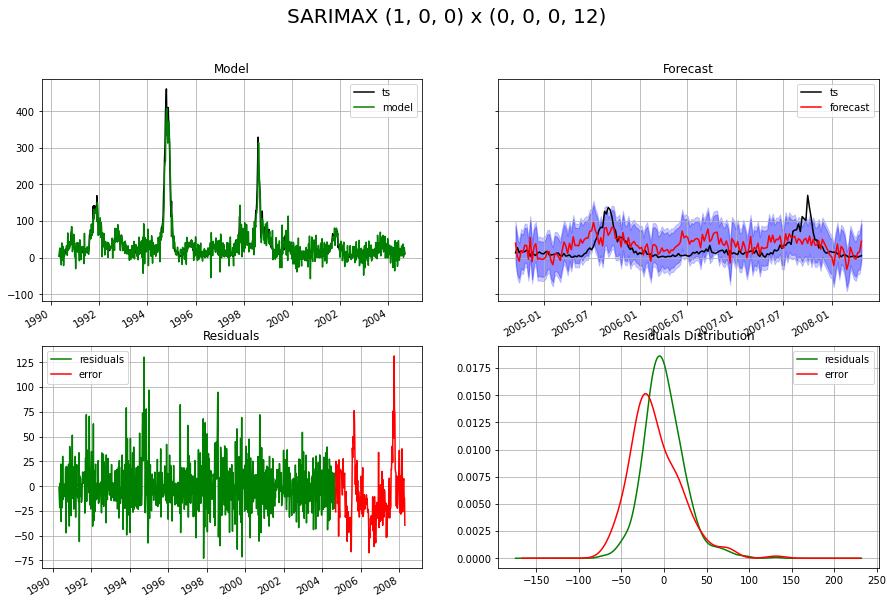

Training --> Residuals mean: 0.0  | std: 24.0
Test --> Error mean: -9.0  | std: 30.0  | mae: 26.0  | mape: inf %  | mse: 1002.0  | rmse: 32.0


In [33]:
dtf, dtf_train, dtf_test, model, predictions = fit_sarimax(ts_train_sj, ts_test_sj, 
                                              order=(1,0,0), 
                                              seasonal_order=(0,0,0,12),
                                              exog_test=ts_exog_test_sj,
                                              exog_train=ts_exog_train_sj)


In [34]:
best_model_iq = pmdarima.auto_arima(ts_iq_monthly, exogenous = ts_exog_iq_monthly, seasonal=True, stationary=False, 
                                 m=12, information_criterion='aic', max_order=20, 
                                 max_p=10, max_d=3, max_q=10, 
                                 max_P=10, max_D=3, max_Q=10,
                                 error_action='ignore')

print("best model --> (p, d, q):", best_model_iq.order, " and  (P, D, Q, s):", best_model_iq.seasonal_order)
print(best_model_iq.summary())

best model --> (p, d, q): (0, 0, 1)  and  (P, D, Q, s): (0, 0, 0, 12)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  102
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -499.355
Date:                Fri, 02 Oct 2020   AIC                           1042.709
Time:                        13:15:47   BIC                           1100.459
Sample:                    01-31-2002   HQIC                          1066.094
                         - 06-30-2010                                         
Covariance Type:                  opg                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
ndvi_ne                                  70.8826    288.121      0.246      0.806    -

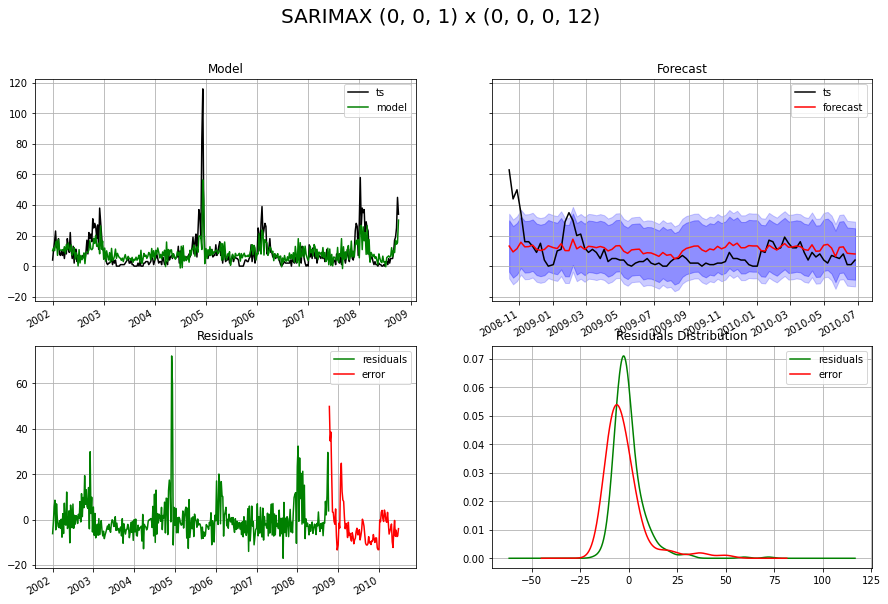

Training --> Residuals mean: -0.0  | std: 9.0
Test --> Error mean: -2.0  | std: 11.0  | mae: 8.0  | mape: inf %  | mse: 121.0  | rmse: 11.0


In [35]:
dtf_iq, dtf_train_iq, dtf_test_iq, model_iq, predictions_iq = fit_sarimax(ts_train_iq, ts_test_iq, 
                                              order=(0,0,1), 
                                              seasonal_order=(0,0,0,12),
                                              exog_test=ts_exog_test_iq,
                                              exog_train=ts_exog_train_iq)